<a href="https://colab.research.google.com/github/Upgrade-crypto/README.md/blob/main/IBM_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import requests
import pandas as pd
import numpy as np
import os # Import the os module

def get_spacex_launch_data():
    """Collect SpaceX launch data from API"""
    url = "https://api.spacexdata.com/v4/launches"
    response = requests.get(url)

    if response.status_code == 200:
        launches = response.json()
        print(f"Retrieved {len(launches)} launches")
        return launches
    else:
        print("Failed to retrieve data")
        return []

def process_launch_data(launches):
    """Process raw launch data into structured format"""
    processed_data = []

    for launch in launches:
        # Extract core information
        cores = launch.get('cores', [])
        first_core = cores[0] if cores else {}

        # Extract payload information
        payloads = launch.get('payloads', [])
        payload_mass = sum([p.get('mass_kg', 0) for p in payloads if isinstance(p, dict)]) # Added check for dictionary type

        # Extract orbit information safely
        orbit_info = None
        if payloads and isinstance(payloads[0], dict):
            orbit_info = payloads[0].get('orbit')

        launch_record = {
            'flight_number': launch.get('flight_number'),
            'launch_date': launch.get('date_utc'),
            'mission_name': launch.get('name'),
            'launch_success': launch.get('success', False),
            'launch_site_id': launch.get('launchpad'),
            'core_serial': first_core.get('core'),
            'landing_success': first_core.get('landing_success'),
            'landing_type': first_core.get('landing_type'),
            'landing_vehicle': first_core.get('landing_vehicle'),
            'payload_mass_kg': payload_mass,
            'orbit': orbit_info # Used the safely extracted orbit_info
        }
        processed_data.append(launch_record)

    return pd.DataFrame(processed_data)

# Main execution
print("Collecting SpaceX launch data...")
launches = get_spacex_launch_data()
df_api = process_launch_data(launches)

print(f"Processed {len(df_api)} records")
print("\nData sample:")
print(df_api.head())
print("\nData columns:")
print(df_api.columns.tolist())

# Save to CSV
df_api.to_csv('spacex_api_data.csv', index=False)
print("\nData saved to spacex_api_data.csv")

# Print the current working directory to help locate the file
print(f"\nCurrent working directory: {os.getcwd()}")

Retrieved 205 launches
Processed 205 records

Data sample:
   flight_number               launch_date mission_name launch_success  \
0              1  2006-03-24T22:30:00.000Z    FalconSat          False   
1              2  2007-03-21T01:10:00.000Z      DemoSat          False   
2              3  2008-08-03T03:34:00.000Z  Trailblazer          False   
3              4  2008-09-28T23:15:00.000Z       RatSat           True   
4              5  2009-07-13T03:35:00.000Z     RazakSat           True   

             launch_site_id               core_serial landing_success  \
0  5e9e4502f5090995de566f86  5e9e289df35918033d3b2623            None   
1  5e9e4502f5090995de566f86  5e9e289ef35918416a3b2624            None   
2  5e9e4502f5090995de566f86  5e9e289ef3591814873b2625            None   
3  5e9e4502f5090995de566f86  5e9e289ef3591855dc3b2626            None   
4  5e9e4502f5090995de566f86  5e9e289ef359184f103b2627            None   

  landing_type landing_vehicle  payload_mass_kg orbit  
0

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def scrape_falcon9_launches():
    """Scrape Falcon 9 launch history from Wikipedia"""
    url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find launch tables (2010–2019 and 2020–present)
    tables = soup.find_all('table', {'class': 'wikitable'})

    all_launches = []

    for table in tables[:2]:  # First two tables contain launch data
        rows = table.find_all('tr')

        for row in rows[1:]:  # Skip header row
            cols = row.find_all(['td', 'th'])
            cols = [col.text.strip() for col in cols]

            if len(cols) >= 8:
                launch_data = {
                    'flight_number': extract_flight_number(cols[0]),
                    'date': cols[1],
                    'booster_version': cols[2],
                    'launch_site': cols[3],
                    'payload': cols[4],
                    'payload_mass': extract_mass(cols[5]),
                    'orbit': cols[6],
                    'customer': cols[7],
                    'outcome': cols[8] if len(cols) > 8 else ''
                }
                all_launches.append(launch_data)

    return pd.DataFrame(all_launches)

def extract_flight_number(text):
    """Extract flight number from text"""
    match = re.search(r'(\d+)', text)
    return int(match.group(1)) if match else None

def extract_mass(text):
    """Extract mass from text"""
    match = re.search(r'(\d[\d,.]*)', text.replace(',', ''))
    return float(match.group(1)) if match else None

# Main execution
print("Scraping Falcon 9 launch data from Wikipedia...")
df_scraped = scrape_falcon9_launches()

print(f"Scraped {len(df_scraped)} records")
print("\nScraped data sample:")
print(df_scraped.head())

# Save to CSV
df_scraped.to_csv('spacex_scraped_data.csv', index=False)
print("\nScraped data saved to spacex_scraped_data.csv")

Scraping Falcon 9 launch data from Wikipedia...
Scraped 264 records

Scraped data sample:
   flight_number                       date booster_version  \
0            286   January 3, 202403:44[23]    F9 B5B1082‑1   
1            287   January 3, 202423:04[24]   F9 B5B1076‑10   
2            288   January 7, 202422:35[28]   F9 B5B1067‑16   
3            289  January 14, 202408:59[30]   F9 B5B1061‑18   
4            290  January 15, 202401:52[31]   F9 B5B1073‑12   

              launch_site                               payload  payload_mass  \
0      Vandenberg, SLC‑4E   Starlink: Group 7-9 (22 satellites)       16800.0   
1  Cape Canaveral, SLC‑40                               Ovzon-3        1800.0   
2  Cape Canaveral, SLC‑40  Starlink: Group 6-35 (23 satellites)       17100.0   
3      Vandenberg, SLC‑4E  Starlink: Group 7-10 (22 satellites)       16700.0   
4  Cape Canaveral, SLC‑40  Starlink: Group 6-37 (23 satellites)       17100.0   

  orbit customer  outcome  
0   LEO   SpaceX

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load data from previous steps
df_api = pd.read_csv('spacex_api_data.csv')
df_scraped = pd.read_csv('spacex_scraped_data.csv')

print("Original API data shape:", df_api.shape)
print("Original scraped data shape:", df_scraped.shape)

# Merge datasets on flight number
df_merged = pd.merge(df_api, df_scraped, on='flight_number', how='inner', suffixes=('_api', '_scraped'))

print("Merged data shape:", df_merged.shape)

# Data cleaning
def clean_data(df):
    # Handle missing values
    df['payload_mass_kg'] = df['payload_mass_kg'].fillna(df['payload_mass_kg'].median())
    # Updated to avoid FutureWarning
    df['landing_success'] = df['landing_success'].fillna(False).astype(bool)

    # Create target variable
    df['class'] = df['landing_success'].astype(int)

    # Feature engineering
    df['launch_year'] = pd.to_datetime(df['launch_date']).dt.year
    df['launch_month'] = pd.to_datetime(df['launch_date']).dt.month

    # Extract booster version - Modified to handle potential missing values
    df['booster_version'] = df['booster_version'].astype(str).str.extract(r'(v\d+\.\d+)')

    # Encode categorical variables - Modified to use 'orbit_scraped' and check for column existence
    le = LabelEncoder()
    categorical_cols = ['launch_site', 'orbit_scraped', 'booster_version'] # Changed 'orbit' to 'orbit_scraped'
    for col in categorical_cols:
        if col in df.columns: # Check if the column exists
            df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
        else:
            print(f"Warning: Column '{col}' not found in DataFrame. Skipping encoding.") # Added warning

    return df

# Clean the data
df_cleaned = clean_data(df_merged)

print("Cleaned data shape:", df_cleaned.shape)
print("\nMissing values after cleaning:")
print(df_cleaned.isnull().sum())

print("\nData types:")
print(df_cleaned.dtypes)

print("\nTarget variable distribution:")
print(df_cleaned['class'].value_counts())

# Save cleaned dataset
df_cleaned.to_csv('spacex_launch_data.csv', index=False)
print("\nCleaned data saved to spacex_launch_data.csv")

Original API data shape: (205, 11)
Original scraped data shape: (264, 9)
Merged data shape: (2, 19)
Cleaned data shape: (2, 25)

Missing values after cleaning:
flight_number              0
launch_date                0
mission_name               0
launch_success             0
launch_site_id             0
core_serial                0
landing_success            0
landing_type               1
landing_vehicle            2
payload_mass_kg            0
orbit_api                  2
date                       0
booster_version            2
launch_site                0
payload                    0
payload_mass               0
orbit_scraped              0
customer                   0
outcome                    0
class                      0
launch_year                0
launch_month               0
launch_site_encoded        0
orbit_scraped_encoded      0
booster_version_encoded    0
dtype: int64

Data types:
flight_number                int64
launch_date                 object
mission_name       

/tmp/ipython-input-2879935976.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['landing_success'] = df['landing_success'].fillna(False).astype(bool)


Dataset Overview:
Shape: (2, 25)
Columns: ['flight_number', 'launch_date', 'mission_name', 'launch_success', 'launch_site_id', 'core_serial', 'landing_success', 'landing_type', 'landing_vehicle', 'payload_mass_kg', 'orbit_api', 'date', 'booster_version', 'launch_site', 'payload', 'payload_mass', 'orbit_scraped', 'customer', 'outcome', 'class', 'launch_year', 'launch_month', 'launch_site_encoded', 'orbit_scraped_encoded', 'booster_version_encoded']


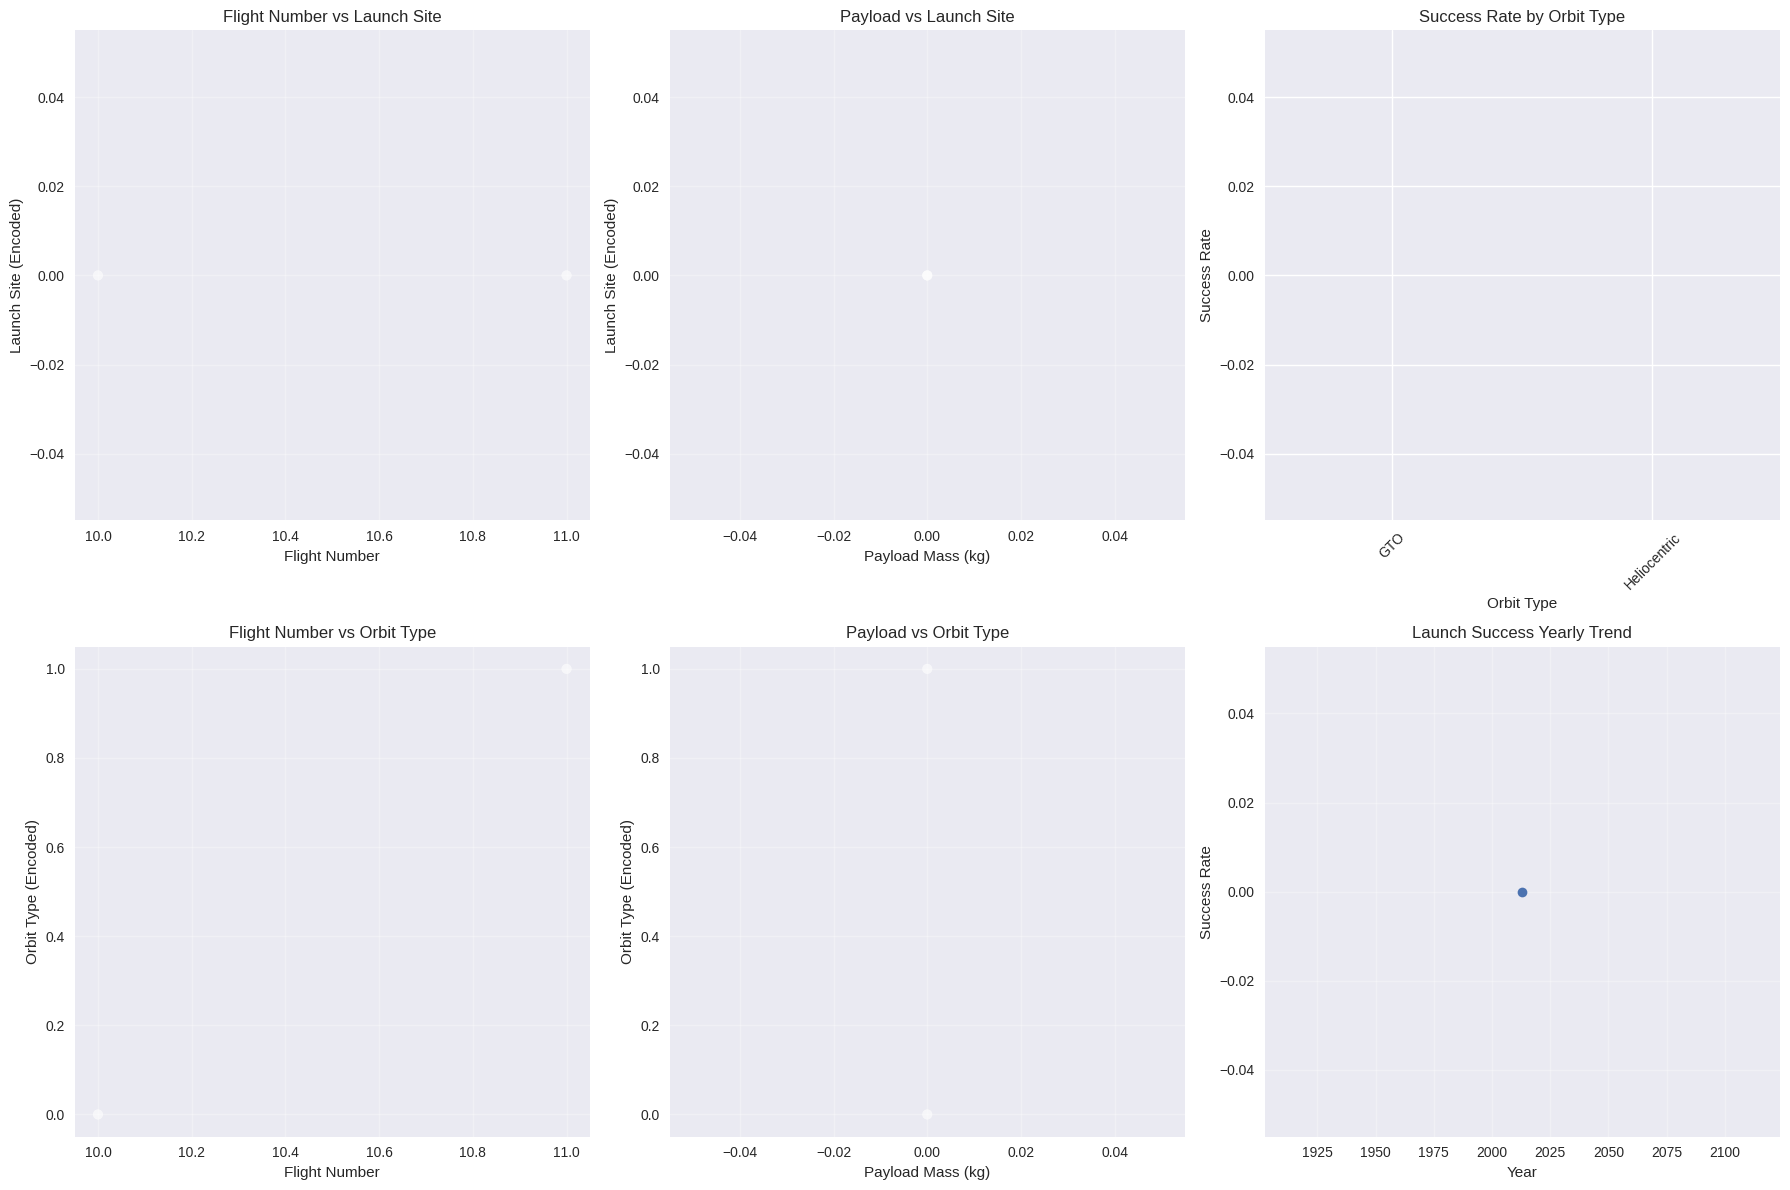


Key Insights:
Overall success rate: 0.00%
Number of unique launch sites: 1
Number of unique orbits: 2
Average payload mass: 0.00 kg


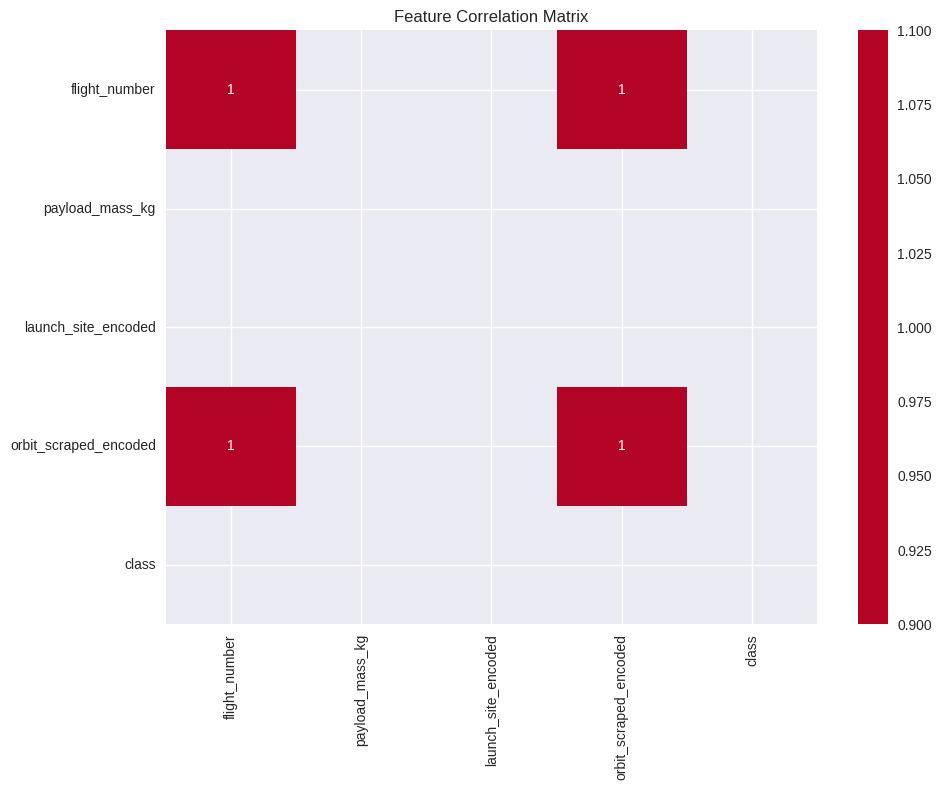

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
df = pd.read_csv('spacex_launch_data.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Set up visualization style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Flight Number vs Launch Site
axes[0,0].scatter(df['flight_number'], df['launch_site_encoded'], alpha=0.6, c=df['class'])
axes[0,0].set_xlabel('Flight Number')
axes[0,0].set_ylabel('Launch Site (Encoded)')
axes[0,0].set_title('Flight Number vs Launch Site')
axes[0,0].grid(True, alpha=0.3)

# 2. Payload vs Launch Site
axes[0,1].scatter(df['payload_mass_kg'], df['launch_site_encoded'], alpha=0.6, c=df['class'])
axes[0,1].set_xlabel('Payload Mass (kg)')
axes[0,1].set_ylabel('Launch Site (Encoded)')
axes[0,1].set_title('Payload vs Launch Site')
axes[0,1].grid(True, alpha=0.3)

# 3. Success Rate by Orbit Type
orbit_success = df.groupby('orbit_scraped')['class'].mean().sort_values(ascending=False) # Changed 'orbit' to 'orbit_scraped'
axes[0,2].bar(orbit_success.index, orbit_success.values, color='skyblue')
axes[0,2].set_xlabel('Orbit Type')
axes[0,2].set_ylabel('Success Rate')
axes[0,2].set_title('Success Rate by Orbit Type')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Flight Number vs Orbit Type
axes[1,0].scatter(df['flight_number'], df['orbit_scraped_encoded'], alpha=0.6, c=df['class']) # Changed 'orbit_encoded' to 'orbit_scraped_encoded'
axes[1,0].set_xlabel('Flight Number')
axes[1,0].set_ylabel('Orbit Type (Encoded)')
axes[1,0].set_title('Flight Number vs Orbit Type')
axes[1,0].grid(True, alpha=0.3)

# 5. Payload vs Orbit Type
axes[1,1].scatter(df['payload_mass_kg'], df['orbit_scraped_encoded'], alpha=0.6, c=df['class']) # Changed 'orbit_encoded' to 'orbit_scraped_encoded'
axes[1,1].set_xlabel('Payload Mass (kg)')
axes[1,1].set_ylabel('Orbit Type (Encoded)')
axes[1,1].set_title('Payload vs Orbit Type')
axes[1,1].grid(True, alpha=0.3)

# 6. Yearly Success Rate Trend
yearly_success = df.groupby('launch_year')['class'].mean()
axes[1,2].plot(yearly_success.index, yearly_success.values, marker='o', linewidth=2)
axes[1,2].set_xlabel('Year')
axes[1,2].set_ylabel('Success Rate')
axes[1,2].set_title('Launch Success Yearly Trend')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional insights
print("\nKey Insights:")
print(f"Overall success rate: {df['class'].mean():.2%}")
print(f"Number of unique launch sites: {df['launch_site'].nunique()}")
print(f"Number of unique orbits: {df['orbit_scraped'].nunique()}") # Changed 'orbit' to 'orbit_scraped'
print(f"Average payload mass: {df['payload_mass_kg'].mean():.2f} kg")

# Correlation analysis
numeric_cols = ['flight_number', 'payload_mass_kg', 'launch_site_encoded', 'orbit_scraped_encoded', 'class'] # Changed 'orbit_encoded' to 'orbit_scraped_encoded'
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
import sqlite3
import pandas as pd

# Create SQLite database and load data
conn = sqlite3.connect('spacex_launches.db')
df = pd.read_csv('spacex_launch_data.csv')
df.to_sql('launches', conn, if_exists='replace', index=False)

print("SQL EDA Analysis Results:\n")

# 1. All Launch Site Names
query1 = "SELECT DISTINCT launch_site FROM launches;"
result1 = pd.read_sql_query(query1, conn)
print("1. All Launch Site Names:")
print(result1)
print()

# 2. Launch sites beginning with 'CCA'
query2 = "SELECT launch_site FROM launches WHERE launch_site LIKE 'CCA%' LIMIT 5;"
result2 = pd.read_sql_query(query2, conn)
print("2. Launch Sites Beginning with 'CCA':")
print(result2)
print()

# 3. Total payload mass (assuming NASA as customer)
query3 = """
SELECT SUM(payload_mass_kg) as total_nasa_payload
FROM launches
WHERE customer LIKE '%NASA%' OR mission_name LIKE '%NASA%';
"""
result3 = pd.read_sql_query(query3, conn)
print("3. Total Payload Mass for NASA:")
print(result3)
print()

# 4. Average payload for F9 v1.1
query4 = """
SELECT AVG(payload_mass_kg) as avg_payload_f9_v1_1
FROM launches
WHERE booster_version LIKE '%v1.1%';
"""
result4 = pd.read_sql_query(query4, conn)
print("4. Average Payload Mass for F9 v1.1:")
print(result4)
print()

# 5. First successful ground landing date
query5 = """
SELECT MIN(launch_date) as first_successful_ground_landing
FROM launches
WHERE landing_success = 1 AND landing_type LIKE '%ground%';
"""
result5 = pd.read_sql_query(query5, conn)
print("5. First Successful Ground Landing Date:")
print(result5)
print()

# 6. Boosters with successful drone ship landing and payload between 4000-6000 kg
query6 = """
SELECT DISTINCT core_serial, booster_version, launch_site
FROM launches
WHERE landing_success = 1
AND landing_vehicle LIKE '%drone%'
AND payload_mass_kg BETWEEN 4000 AND 6000;
"""
result6 = pd.read_sql_query(query6, conn)
print("6. Successful Drone Ship Landings (Payload 4000-6000 kg):")
print(result6)
print()

# 7. Total successful and failed missions
query7 = """
SELECT
    SUM(launch_success) as successful_missions,
    SUM(NOT launch_success) as failed_missions
FROM launches;
"""
result7 = pd.read_sql_query(query7, conn)
print("7. Total Mission Outcomes:")
print(result7)
print()

# 8. Boosters with maximum payload mass
query8 = """
SELECT core_serial, booster_version, MAX(payload_mass_kg) as max_payload
FROM launches
GROUP BY core_serial, booster_version
ORDER BY max_payload DESC
LIMIT 5;
"""
result8 = pd.read_sql_query(query8, conn)
print("8. Boosters with Maximum Payload Mass:")
print(result8)
print()

# 9. 2015 launch records with failed outcomes
query9 = """
SELECT core_serial, booster_version, launch_site, landing_type
FROM launches
WHERE strftime('%Y', launch_date) = '2015'
AND landing_success = 0
AND landing_vehicle LIKE '%drone%';
"""
result9 = pd.read_sql_query(query9, conn)
print("9. 2015 Failed Drone Ship Landings:")
print(result9)
print()

# 10. Rank landing outcomes between specific dates
query10 = """
SELECT
    landing_type,
    COUNT(*) as outcome_count
FROM launches
WHERE date(launch_date) BETWEEN '2010-06-04' AND '2017-03-20'
AND landing_type IS NOT NULL
GROUP BY landing_type
ORDER BY outcome_count DESC;
"""
result10 = pd.read_sql_query(query10, conn)
print("10. Landing Outcomes Ranked (2010-2017):")
print(result10)

conn.close()

SQL EDA Analysis Results:

1. All Launch Site Names:
       launch_site
0  Kennedy, LC‑39A

2. Launch Sites Beginning with 'CCA':
Empty DataFrame
Columns: [launch_site]
Index: []

3. Total Payload Mass for NASA:
   total_nasa_payload
0                   0

4. Average Payload Mass for F9 v1.1:
  avg_payload_f9_v1_1
0                None

5. First Successful Ground Landing Date:
  first_successful_ground_landing
0                            None

6. Successful Drone Ship Landings (Payload 4000-6000 kg):
Empty DataFrame
Columns: [core_serial, booster_version, launch_site]
Index: []

7. Total Mission Outcomes:
   successful_missions  failed_missions
0                    2                0

8. Boosters with Maximum Payload Mass:
                core_serial booster_version  max_payload
0  5e9e289ff359180ae23b262d            None            0
1  5e9e289ff3591884e03b262c            None            0

9. 2015 Failed Drone Ship Landings:
Empty DataFrame
Columns: [core_serial, booster_version, la

In [9]:
import folium
from folium import plugins
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('spacex_launch_data.csv')

# Launch site coordinates (approximate)
launch_sites = {
    'CCAFS SLC 40': (28.5623, -80.5774),
    'KSC LC 39A': (28.5733, -80.6467),
    'VAFB SLC 4E': (34.6321, -120.6107)
}

# Create base map
m = folium.Map(location=[35, -100], zoom_start=4)

# Add launch sites with markers
for site, coords in launch_sites.items():
    site_data = df[df['launch_site'] == site]
    success_rate = site_data['class'].mean()

    # Color based on success rate
    color = 'green' if success_rate > 0.7 else 'orange' if success_rate > 0.5 else 'red'

    popup_text = f"""
    <b>{site}</b><br>
    Total Launches: {len(site_data)}<br>
    Success Rate: {success_rate:.2%}<br>
    Avg Payload: {site_data['payload_mass_kg'].mean():.0f} kg
    """

    folium.Marker(
        coords,
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=site,
        icon=folium.Icon(color=color, icon='rocket', prefix='fa')
    ).add_to(m)

# Add circles for proximity analysis
for site, coords in launch_sites.items():
    folium.Circle(
        coords,
        radius=50000,  # 50km radius
        popup=f'{site} - 50km Radius',
        color='blue',
        fill=True,
        fillOpacity=0.1
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map
m.save('spacex_launch_sites.html')
print("Interactive map saved as 'spacex_launch_sites.html'")

# Create second map with launch outcomes
m2 = folium.Map(location=[35, -100], zoom_start=4)

# Add markers colored by outcome
for idx, row in df.iterrows():
    if pd.notna(row['launch_site']) and row['launch_site'] in launch_sites:
        coords = launch_sites[row['launch_site']]
        color = 'green' if row['class'] == 1 else 'red'

        popup_text = f"""
        <b>Flight {row['flight_number']}</b><br>
        Mission: {row['mission_name']}<br>
        Date: {row['launch_date']}<br>
        Payload: {row['payload_mass_kg']:.0f} kg<br>
        Orbit: {row['orbit']}<br>
        Outcome: {'Success' if row['class'] == 1 else 'Failure'}
        """

        folium.CircleMarker(
            coords,
            radius=8,
            popup=folium.Popup(popup_text, max_width=300),
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(m2)

m2.save('spacex_launch_outcomes.html')
print("Outcome map saved as 'spacex_launch_outcomes.html'")

Interactive map saved as 'spacex_launch_sites.html'
Outcome map saved as 'spacex_launch_outcomes.html'


In [13]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('spacex_launch_data.csv')

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("SpaceX Launch Analysis Dashboard",
            style={'textAlign': 'center', 'color': '#2c3e50'}),

    html.Div([
        # Overall success pie chart
        dcc.Graph(id='overall-success-pie'),

        # Payload vs Outcome scatter plot
        dcc.Graph(id='payload-outcome-scatter'),
    ], style={'display': 'flex', 'flexWrap': 'wrap'}),

    html.Div([
        # Range slider for payload mass
        dcc.RangeSlider(
            id='payload-slider',
            min=df['payload_mass_kg'].min(),
            max=df['payload_mass_kg'].max(),
            step=1000,
            value=[df['payload_mass_kg'].min(), df['payload_mass_kg'].max()],
            marks={i: f'{i}kg' for i in range(0, int(df['payload_mass_kg'].max())+1, 5000)}
        ),
    ], style={'width': '80%', 'margin': '20px auto'}),

    html.Div([
        # Launch site success rates
        dcc.Graph(id='site-success-bar'),
    ]),
])

@app.callback(
    [Output('overall-success-pie', 'figure'),
     Output('payload-outcome-scatter', 'figure'),
     Output('site-success-bar', 'figure')],
    [Input('payload-slider', 'value')]
)
def update_dashboard(payload_range):
    # Filter data based on payload range
    filtered_df = df[(df['payload_mass_kg'] >= payload_range[0]) &
                     (df['payload_mass_kg'] <= payload_range[1])]

    # Overall success pie chart
    success_count = filtered_df['class'].value_counts()
    pie_fig = px.pie(
        values=success_count.values,
        names=['Failure', 'Success'],
        title='Overall Launch Success Rate',
        color=['Failure', 'Success'],
        color_discrete_map={'Success':'green', 'Failure':'red'}
    )

    # Payload vs Outcome scatter plot
    scatter_fig = px.scatter(
        filtered_df,
        x='payload_mass_kg',
        y='flight_number',
        color='class',
        color_continuous_scale=['red', 'green'],
        title='Payload Mass vs Flight Outcome',
        labels={'payload_mass_kg': 'Payload Mass (kg)', 'flight_number': 'Flight Number'}
    )

    # Launch site success rates
    site_success = filtered_df.groupby('launch_site')['class'].mean().reset_index()
    bar_fig = px.bar(
        site_success,
        x='launch_site',
        y='class',
        title='Success Rate by Launch Site',
        labels={'class': 'Success Rate', 'launch_site': 'Launch Site'},
        color='class',
        color_continuous_scale='Viridis'
    )

    return pie_fig, scatter_fig, bar_fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)

ObsoleteAttributeException: app.run_server has been replaced by app.run

In [12]:
!pip install dash pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.3 MB/s eta 0:00:00


In [14]:
!pip install dash pandas plotly

The Dash app requires the `dash`, `pandas`, and `plotly` libraries. The previous cell installs these dependencies.

After installing the libraries, you can run the Dash application by executing the following cell. Note that you may need to expose port 8050 for the dashboard to be accessible. In Google Colab, this is usually handled automatically when you run a Dash app.

In [17]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('spacex_launch_data.csv')

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("SpaceX Launch Analysis Dashboard",
            style={'textAlign': 'center', 'color': '#2c3e50'}),

    html.Div([
        # Overall success pie chart
        dcc.Graph(id='overall-success-pie'),

        # Payload vs Outcome scatter plot
        dcc.Graph(id='payload-outcome-scatter'),
    ], style={'display': 'flex', 'flexWrap': 'wrap'}),

    html.Div([
        # Range slider for payload mass
        dcc.RangeSlider(
            id='payload-slider',
            min=df['payload_mass_kg'].min(),
            max=df['payload_mass_kg'].max(),
            step=1000,
            value=[df['payload_mass_kg'].min(), df['payload_mass_kg'].max()],
            marks={i: f'{i}kg' for i in range(0, int(df['payload_mass_kg'].max())+1, 5000)}
        ),
    ], style={'width': '80%', 'margin': '20px auto'}),

    html.Div([
        # Launch site success rates
        dcc.Graph(id='site-success-bar'),
    ]),
])

@app.callback(
    [Output('overall-success-pie', 'figure'),
     Output('payload-outcome-scatter', 'figure'),
     Output('site-success-bar', 'figure')],
    [Input('payload-slider', 'value')]
)
def update_dashboard(payload_range):
    # Filter data based on payload range
    filtered_df = df[(df['payload_mass_kg'] >= payload_range[0]) &
                     (df['payload_mass_kg'] <= payload_range[1])]

    # Overall success pie chart
    success_count = filtered_df['class'].value_counts()
    pie_fig = px.pie(
        values=success_count.values,
        names=['Failure', 'Success'],
        title='Overall Launch Success Rate',
        color=['Failure', 'Success'],
        color_discrete_map={'Success':'green', 'Failure':'red'}
    )

    # Payload vs Outcome scatter plot
    scatter_fig = px.scatter(
        filtered_df,
        x='payload_mass_kg',
        y='flight_number',
        color='class',
        color_continuous_scale=['red', 'green'],
        title='Payload Mass vs Flight Outcome',
        labels={'payload_mass_kg': 'Payload Mass (kg)', 'flight_number': 'Flight Number'}
    )

    # Launch site success rates
    site_success = filtered_df.groupby('launch_site')['class'].mean().reset_index()
    bar_fig = px.bar(
        site_success,
        x='launch_site',
        y='class',
        title='Success Rate by Launch Site',
        labels={'class': 'Success Rate', 'launch_site': 'Launch Site'},
        color='class',
        color_continuous_scale='Viridis'
    )

    return pie_fig, scatter_fig, bar_fig

if __name__ == '__main__':
    app.run(debug=True, port=8050) # Changed run_server to run

<IPython.core.display.Javascript object>

The Dash app requires the `dash`, `pandas`, and `plotly` libraries. The previous cell installs these dependencies.

After installing the libraries, you can run the Dash application by executing the following cell. Note that you may need to expose port 8050 for the dashboard to be accessible. In Google Colab, this is usually handled automatically when you run a Dash app.

In [18]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('spacex_launch_data.csv')

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("SpaceX Launch Analysis Dashboard",
            style={'textAlign': 'center', 'color': '#2c3e50'}),

    html.Div([
        # Overall success pie chart
        dcc.Graph(id='overall-success-pie'),

        # Payload vs Outcome scatter plot
        dcc.Graph(id='payload-outcome-scatter'),
    ], style={'display': 'flex', 'flexWrap': 'wrap'}),

    html.Div([
        # Range slider for payload mass
        dcc.RangeSlider(
            id='payload-slider',
            min=df['payload_mass_kg'].min(),
            max=df['payload_mass_kg'].max(),
            step=1000,
            value=[df['payload_mass_kg'].min(), df['payload_mass_kg'].max()],
            marks={i: f'{i}kg' for i in range(0, int(df['payload_mass_kg'].max())+1, 5000)}
        ),
    ], style={'width': '80%', 'margin': '20px auto'}),

    html.Div([
        # Launch site success rates
        dcc.Graph(id='site-success-bar'),
    ]),
])

@app.callback(
    [Output('overall-success-pie', 'figure'),
     Output('payload-outcome-scatter', 'figure'),
     Output('site-success-bar', 'figure')],
    [Input('payload-slider', 'value')]
)
def update_dashboard(payload_range):
    # Filter data based on payload range
    filtered_df = df[(df['payload_mass_kg'] >= payload_range[0]) &
                     (df['payload_mass_kg'] <= payload_range[1])]

    # Overall success pie chart
    success_count = filtered_df['class'].value_counts()
    pie_fig = px.pie(
        values=success_count.values,
        names=['Failure', 'Success'],
        title='Overall Launch Success Rate',
        color=['Failure', 'Success'],
        color_discrete_map={'Success':'green', 'Failure':'red'}
    )

    # Payload vs Outcome scatter plot
    scatter_fig = px.scatter(
        filtered_df,
        x='payload_mass_kg',
        y='flight_number',
        color='class',
        color_continuous_scale=['red', 'green'],
        title='Payload Mass vs Flight Outcome',
        labels={'payload_mass_kg': 'Payload Mass (kg)', 'flight_number': 'Flight Number'}
    )

    # Launch site success rates
    site_success = filtered_df.groupby('launch_site')['class'].mean().reset_index()
    bar_fig = px.bar(
        site_success,
        x='launch_site',
        y='class',
        title='Success Rate by Launch Site',
        labels={'class': 'Success Rate', 'launch_site': 'Launch Site'},
        color='class',
        color_continuous_scale='Viridis'
    )

    return pie_fig, scatter_fig, bar_fig

if __name__ == '__main__':
    app.run(debug=True, port=8050) # Changed run_server to run

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # Corrected typo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Load and prepare data
df = pd.read_csv('spacex_launch_data.csv')

# Select features for modeling
features = ['flight_number', 'payload_mass_kg', 'launch_site_encoded', 'orbit_scraped_encoded', 'launch_year']
X = df[features]
y = df['class']

# Handle missing values
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Define models and parameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

# Train and evaluate models
results = {}
best_model = None
best_accuracy = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (name, model_info) in enumerate(models.items()):
    # Create pipeline with scaler and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info['model'])
    ])

    # Grid search
    grid_search = GridSearchCV(
        pipeline,
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Predictions
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'model': grid_search.best_estimator_,
        'accuracy': accuracy,
        'best_params': grid_search.best_params_
    }

    # Update best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_

    print(f"\n{name}:")
    print(f"Best Accuracy: {accuracy:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))

# Model comparison visualization
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

axes[0,0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0,0].set_title('Model Comparison - Classification Accuracy')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Confusion matrix for best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
y_pred_best = results[best_model_name]['model'].predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# Feature importance (for tree-based models)
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    importances = best_model.named_steps['model'].feature_importances_
    feature_imp = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values('importance', ascending=True)

    axes[1,0].barh(feature_imp['feature'], feature_imp['importance'])
    axes[1,0].set_title('Feature Importance - Random Forest')
    axes[1,0].set_xlabel('Importance')

# Actual vs Predicted
axes[1,1].scatter(range(len(y_test)), y_test, alpha=0.7, label='Actual', s=50)
axes[1,1].scatter(range(len(y_test)), y_pred_best, alpha=0.7, label='Predicted', s=30)
axes[1,1].set_title('Actual vs Predicted Outcomes')
axes[1,1].set_xlabel('Sample Index')
axes[1,1].set_ylabel('Outcome (0=Fail, 1=Success)')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_spacex_model.pkl')
print("Best model saved as 'best_spacex_model.pkl'")

FileNotFoundError: [Errno 2] No such file or directory: 'spacex_launch_data.csv'